In [2]:
from keras.layers import Input, Dense, Activation, Dropout, LeakyReLU, Lambda, PReLU
from keras.models import Model, Sequential, model_from_json
from keras.callbacks import EarlyStopping
from keras import optimizers, activations, regularizers
from keras import backend as K
from sklearn.model_selection import train_test_split, KFold
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import json

Using TensorFlow backend.


In [3]:
#### File path
data = scipy.io.loadmat('/Users/maggiezhang/Desktop/NRLMSISE_1997_2008_ROM_r100.mat')

# Reduced-order density data
dens_data = data.get('densityDataLogVarROM100')
dens_data = np.array(dens_data).T

# Space weather data
sw_data = data.get('SWdataFull')
sw_data = np.array(sw_data)

# Number of future predictions to make 
pred_number = 24

# Only consider first 10 modes/dimensions of reduced data
dens_data = dens_data[:,0:10]

'''Training data'''
split_15 = int(dens_data.shape[0]*0.85) # manual test split 

dens_data_train = dens_data[0:split_15-pred_number,:]
sw_data_train = sw_data[0:split_15-pred_number,:]
sw_data_train_append = sw_data[1:split_15-pred_number+1,:] #looks at next sw timestep because it could be useful in prediction 
sw_data_train = np.concatenate((sw_data_train, sw_data_train_append), axis=1)
x_train = np.concatenate((dens_data_train, sw_data_train), axis=1)

# Training output
y_train = dens_data[1:split_15-pred_number+1,:]

'''ROM LINEAR MATRICES''' 
Om = np.append(np.transpose(dens_data_train), np.transpose(sw_data_train), axis = 0)
X2 = np.transpose(y_train)

# Compute dynamic matrices:
Phi = np.matmul(X2,np.linalg.pinv(Om))

r = 10 #reduced order 
A = Phi[:r, :r]
B = Phi[:r, r:]

'''Test data'''
# Test input
dens_data_test = dens_data[split_15-pred_number-1:-pred_number-2,:]
sw_data_test = sw_data[split_15-pred_number-1:-pred_number-2,:]
sw_data_test_append = sw_data[split_15-pred_number:-pred_number-1,:]
sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
x_test = np.concatenate((dens_data_test, sw_data_test), axis=1)

# Test output
y_test = dens_data[split_15-pred_number:-pred_number-1,:]
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.17647) #, random_state=42)

## Create FF NN model

In [23]:
model = Sequential()
model.add(Dense(120, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(40, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(20, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(10, kernel_initializer='random_uniform'))

ad = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=ad, loss='mse', metrics=['accuracy'])
history = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), epochs = 500, batch_size = 16)

Train on 73614 samples, validate on 15775 samples
Epoch 1/500
73614/73614 [==============================] - 4s 57us/step - loss: 8.2490 - accuracy: 0.9052 - val_loss: 0.9206 - val_accuracy: 0.9776
Epoch 2/500
73614/73614 [==============================] - 4s 52us/step - loss: 0.5811 - accuracy: 0.9847 - val_loss: 0.2950 - val_accuracy: 0.9883
Epoch 3/500
73614/73614 [==============================] - 4s 53us/step - loss: 0.2278 - accuracy: 0.9885 - val_loss: 0.2028 - val_accuracy: 0.9871
Epoch 4/500
73614/73614 [==============================] - 4s 52us/step - loss: 0.1479 - accuracy: 0.9897 - val_loss: 0.1774 - val_accuracy: 0.9875
Epoch 5/500
73614/73614 [==============================] - 4s 52us/step - loss: 0.0985 - accuracy: 0.9910 - val_loss: 0.0695 - val_accuracy: 0.9925
Epoch 6/500
73614/73614 [==============================] - 4s 53us/step - loss: 0.0816 - accuracy: 0.9916 - val_loss: 0.0507 - val_accuracy: 0.9932
Epoch 7/500
73614/73614 [==============================] - 4s 

Epoch 56/500
73614/73614 [==============================] - 4s 60us/step - loss: 0.0183 - accuracy: 0.9959 - val_loss: 0.0105 - val_accuracy: 0.9971
Epoch 57/500
73614/73614 [==============================] - 4s 54us/step - loss: 0.0175 - accuracy: 0.9962 - val_loss: 0.0101 - val_accuracy: 0.9965
Epoch 58/500
73614/73614 [==============================] - 4s 52us/step - loss: 0.0173 - accuracy: 0.9959 - val_loss: 0.0116 - val_accuracy: 0.9958
Epoch 59/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0172 - accuracy: 0.9961 - val_loss: 0.0123 - val_accuracy: 0.9974
Epoch 60/500
73614/73614 [==============================] - 4s 52us/step - loss: 0.0164 - accuracy: 0.9960 - val_loss: 0.0171 - val_accuracy: 0.9950
Epoch 61/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0169 - accuracy: 0.9963 - val_loss: 0.0279 - val_accuracy: 0.9956
Epoch 62/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0163 - accuracy: 0.9962

Epoch 111/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0105 - accuracy: 0.9969 - val_loss: 0.0104 - val_accuracy: 0.9964
Epoch 112/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0109 - accuracy: 0.9971 - val_loss: 0.0094 - val_accuracy: 0.9978
Epoch 113/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0101 - accuracy: 0.9969 - val_loss: 0.0097 - val_accuracy: 0.9956
Epoch 114/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0105 - accuracy: 0.9969 - val_loss: 0.0064 - val_accuracy: 0.9972
Epoch 115/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0101 - accuracy: 0.9970 - val_loss: 0.0150 - val_accuracy: 0.9966
Epoch 116/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0102 - accuracy: 0.9970 - val_loss: 0.0082 - val_accuracy: 0.9965
Epoch 117/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0107 - accuracy:

KeyboardInterrupt: 

In [42]:
history = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), epochs = 500, batch_size = 16)

Train on 73614 samples, validate on 15775 samples
Epoch 1/500
73614/73614 [==============================] - 5s 63us/step - loss: 0.0037 - accuracy: 0.9982 - val_loss: 0.0045 - val_accuracy: 0.9963
Epoch 2/500
73614/73614 [==============================] - 5s 71us/step - loss: 0.0035 - accuracy: 0.9983 - val_loss: 0.0038 - val_accuracy: 0.9980
Epoch 3/500
73614/73614 [==============================] - 5s 73us/step - loss: 0.0036 - accuracy: 0.9981 - val_loss: 0.0030 - val_accuracy: 0.9984
Epoch 4/500
73614/73614 [==============================] - 6s 76us/step - loss: 0.0036 - accuracy: 0.9982 - val_loss: 0.0025 - val_accuracy: 0.9987
Epoch 5/500
73614/73614 [==============================] - 6s 84us/step - loss: 0.0034 - accuracy: 0.9982 - val_loss: 0.0026 - val_accuracy: 0.9978
Epoch 6/500
73614/73614 [==============================] - 7s 94us/step - loss: 0.0037 - accuracy: 0.9982 - val_loss: 0.0035 - val_accuracy: 0.9978
Epoch 7/500
73614/73614 [==============================] - 7s 

KeyboardInterrupt: 

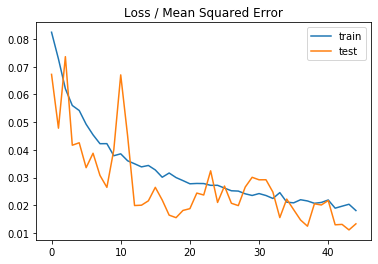

In [20]:
plt.figure()
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'][5:], label='train')
plt.plot(history.history['val_loss'][5:], label='test')
plt.legend()

### If retrained model with new data
> save the file into a json and h5 version to later load into keras

In [45]:
model_json = model.to_json()
with open("Models/NRLMSIS_POD.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("Models/NRLMSIS_POD.h5")
print("Saved model")

Saved model


In [7]:
with open('Models/NRLMSIS_POD.json','r') as f:
    model_NN_json = json.load(f)
    model_NN_json = json.dumps(model_NN_json)
    model_NN_json = str(model_NN_json)

model_NN = model_from_json(model_NN_json)
model_NN.load_weights('Models/NRLMSIS_POD.h5')
model_NN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 120)               3960      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 120)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 40)                4840      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 40)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 20)                820       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 20)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)               

## Time Series predictions for NN and DMDc


[[0.01951879 0.03914652 0.05629102 0.07366176 0.0920679  0.11171567
  0.1326219  0.15456942 0.17750055 0.20142147 0.22626473 0.25209059
  0.27894158 0.30686556 0.33595961 0.36628732 0.3978456  0.43066163
  0.46471503 0.49992014 0.53625795 0.57376498 0.61250158 0.65264269]]
[[0.0730793  0.24985528 0.50182695 0.81260242 1.14795964 1.48797291
  1.82753735 2.14323684 2.42593438 2.68066433 2.89459148 3.06673618
  3.20735964 3.31325556 3.39012388 3.45279835 3.49793934 3.53073367
  3.56540137 3.59962081 3.63932255 3.69892447 3.77562789 3.87310541]]


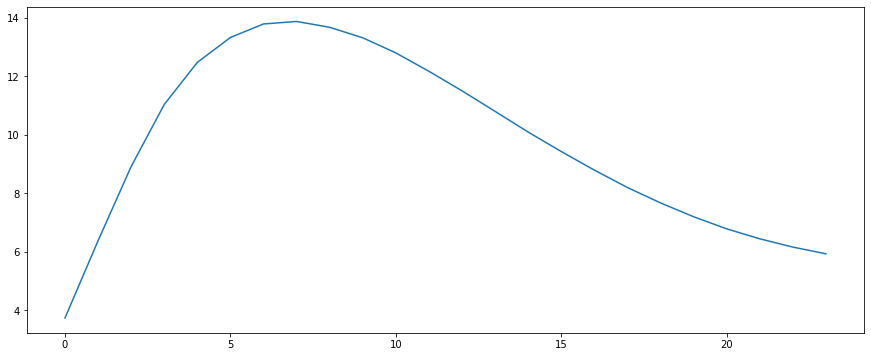

In [8]:
mse_NN = np.zeros((1,pred_number))
mse_ROM = np.zeros((1,pred_number))

x_test_rom = np.copy(x_test)
x_test_NN = np.copy(x_test)
y_test_NN = np.copy(y_test)

prediction_NN = np.empty((15778,10))
prediction_POD = np.empty((15778,10))

for b in range(pred_number):
    y_pred = model_NN.predict(x_test_NN)
    y_test_NN = dens_data[split_15-pred_number+b:-pred_number-1+b,:]
    mse_NN[0][b] = np.sum(np.square(y_test_NN-y_pred))/(y_pred.shape[1]*y_pred.shape[0])
    mse2 = np.sum(np.square(y_pred-y_test_NN),axis = 1)
    sw_data_test = sw_data[split_15-pred_number+b:-pred_number-1+b,:]
    sw_data_test_append = sw_data[split_15-pred_number+1+b:-pred_number+b,:]
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    x_test_NN = np.concatenate((y_pred, sw_data_test), axis=1)

print(mse_NN) 

for a in range(pred_number):
    y_test = dens_data[split_15-pred_number+a:-pred_number-1+a,:]
    sw_data_test = sw_data[split_15-pred_number-1+a:-pred_number-2+a,:]
    sw_data_test_append = sw_data[split_15-pred_number+a:-pred_number-1+a,:]
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    if (a!= 0):
        x_test_rom = np.concatenate((x_test_rom, sw_data_test), axis=1)
    sw_data_test_ROM = x_test_rom[:,10:]
    dens_data_test_ROM = x_test_rom[:,:10]
    XfullPred = np.transpose(np.matmul(A,np.transpose(dens_data_test_ROM)) + np.matmul(B,np.transpose(sw_data_test_ROM)))
    prediction_POD = np.append(prediction_POD, XfullPred, axis =0)
    x_test_rom = np.copy(XfullPred)
    errFullPred = abs(XfullPred-y_test)
    mse_ROM[0][a] = np.sum(np.square(errFullPred))/(errFullPred.shape[1]*errFullPred.shape[0])
    mse_rom2 = np.sum(np.square(errFullPred),axis = 1)
    
print(mse_ROM) 

factor = np.divide(np.transpose(mse_ROM), np.transpose(mse_NN))
plt.figure(figsize = (15,6))
plt.plot(factor)

## Ratio and Error Plots between NN and DMDc


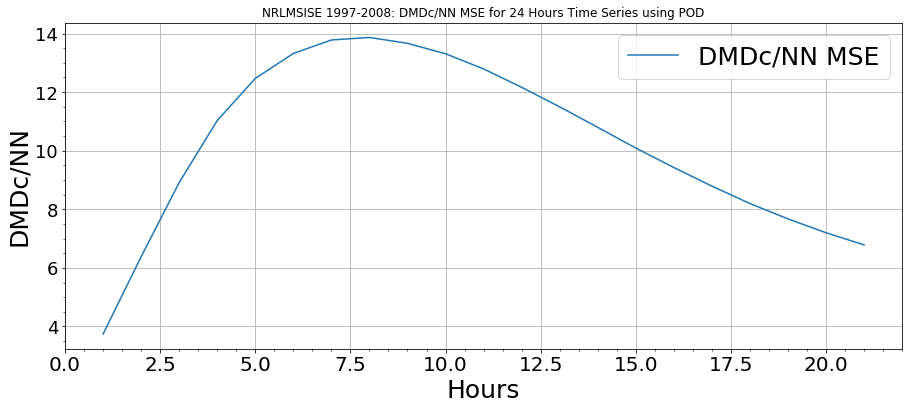

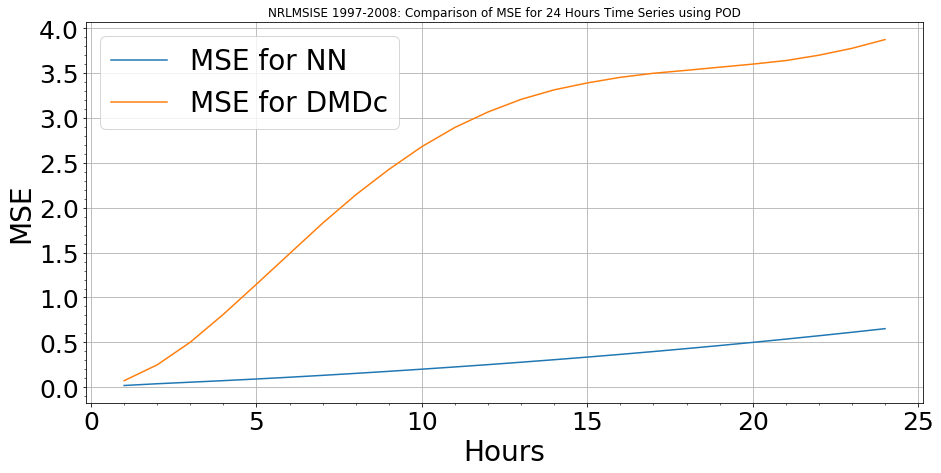

In [9]:
plt.figure(figsize = (15,6))
plt.title("NRLMSISE 1997-2008: DMDc/NN MSE for 24 Hours Time Series using POD")
plt.plot(range(1,1+len(factor[:-3])),factor[:-3], label = "DMDc/NN MSE")
plt.grid()
plt.minorticks_on()
plt.legend(fontsize=25)
plt.xlabel("Hours", fontsize=25)
plt.ylabel("DMDc/NN", fontsize=25)
plt.xticks(size = 20)
plt.yticks(size = 18)
plt.savefig('POD_NRLMSISE_ratio_48.png')  

plt.figure(figsize = (15,7))
plt.title("NRLMSISE 1997-2008: Comparison of MSE for 24 Hours Time Series using POD")
plt.plot(range(1,1+len(factor)),mse_NN.T, label = "MSE for NN")
plt.plot(range(1,1+len(factor)),mse_ROM.T, label = "MSE for DMDc")
plt.grid()
plt.minorticks_on()
plt.xlabel("Hours",fontsize=28)
plt.ylabel("MSE",fontsize=28)
plt.legend(fontsize=28)
plt.xticks(size = 25)
plt.yticks(size = 25)
plt.savefig('POD_NRLMSISE_both_48.png')

## Predict future timesteps to reconstruct full space density

In [10]:
x_test_NN = x_test[0,:]
x_test_NN= np.reshape(x_test_NN, (1, 32))
x_test_rom = np.reshape(x_test[0,:10], (1, 10))

NN_prediction = None
for b in range(pred_number):
    y_pred = model_NN.predict(x_test_NN)
    if b == 0:
        NN_prediction = y_pred
    else:
        NN_prediction = np.append(NN_prediction, y_pred, axis = 0)
    sw_data_test = np.reshape(sw_data[b,:], (1,11))
    sw_data_test_append = np.reshape(sw_data[b+1,:],(1,11))
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    x_test_NN = np.concatenate((y_pred, sw_data_test), axis=1)
    
DMDc_prediction = None
for a in range(pred_number):
    sw_data_test = np.reshape(sw_data[a,:], (1,11))
    sw_data_test_append = np.reshape(sw_data[a+1,:], (1,11))
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    x_test_rom = np.transpose(np.matmul(A,np.transpose(x_test_rom)) + np.matmul(B,np.transpose(sw_data_test)))
    if not a:
        DMDc_prediction = x_test_rom
    else:
        DMDc_prediction = np.append(DMDc_prediction, x_test_rom, axis = 0)

In [11]:
actual = y_test[:pred_number,:]
NN_error = (NN_prediction-actual)
DMDc_error = (DMDc_prediction-actual)

In [12]:
u = data.get("U100")
densityDataMeanLog = data.get("densityDataMeanLog")

In [13]:
nndecoded = np.matmul(u[:,:r], NN_prediction.T)
DMDcdecoded = np.matmul(u[:,:r], DMDc_prediction.T)
actualdecoded = np.matmul(u[:,:r], actual.T)
NN_error_decoded = np.matmul(u[:,:r], NN_error.T)
DMDc_error_decoded = np.matmul(u[:,:r], DMDc_error.T)

In [14]:
matrixof10 = np.full((17280, pred_number), 10)
densityNNPred = np.power(matrixof10,(nndecoded+densityDataMeanLog)).T
densityDMDcPred = np.power(matrixof10,(DMDcdecoded+densityDataMeanLog)).T
actualPred = np.power(matrixof10,(actualdecoded+densityDataMeanLog)).T
densityNNPred_Error = np.power(matrixof10,(NN_error_decoded+actualdecoded+densityDataMeanLog)).T-actualPred
densityDMDcPred_Error = np.power(matrixof10,(DMDc_error_decoded+actualdecoded+densityDataMeanLog)).T-actualPred

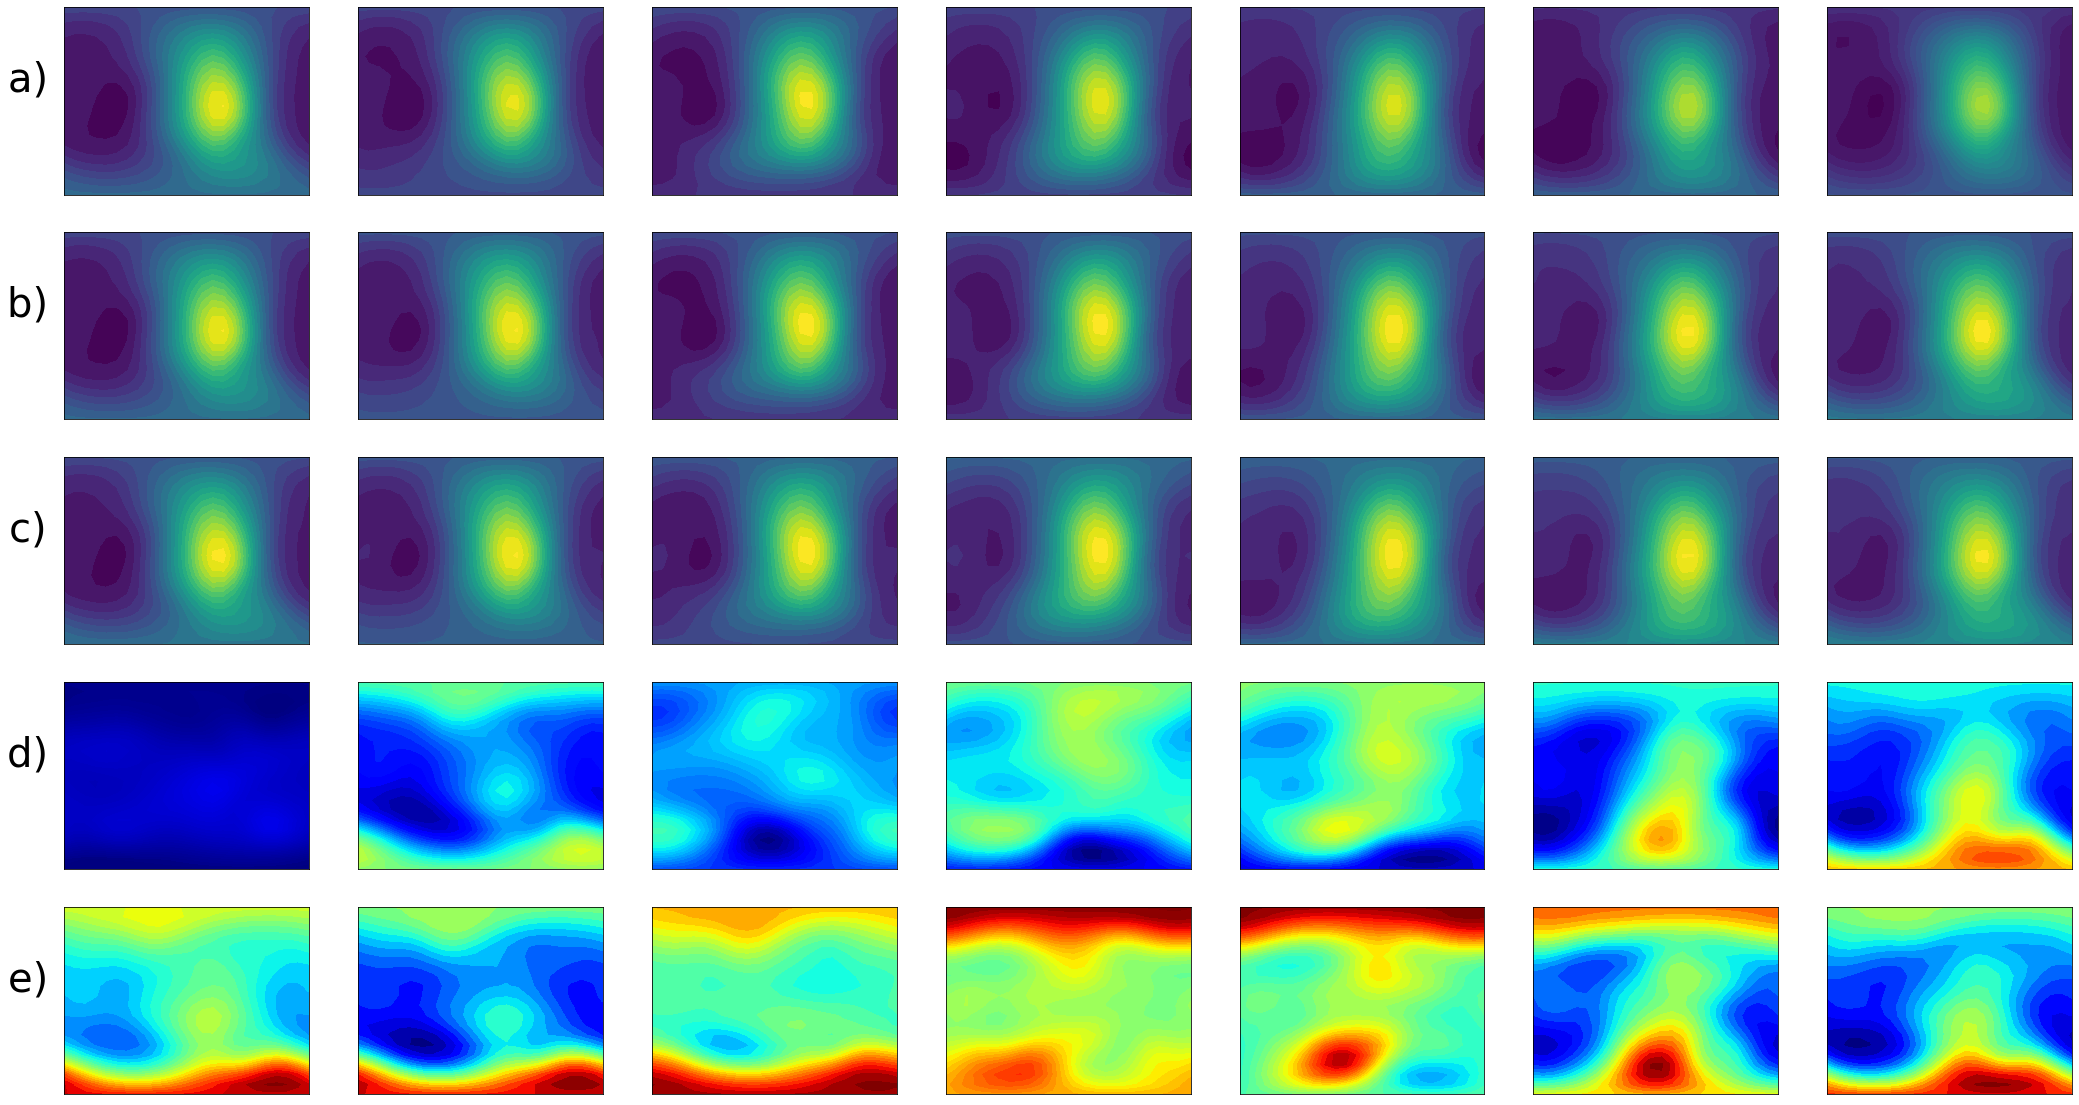

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [63]:
hours = [0,3,7,11,15,19,23] #Prediction hours

cols = len(hours)
rows = 5
fig = plt.figure(figsize = (36,20))

for h in range(len(hours)):
    hr = hours[h]
    nndecoded_1 = np.reshape(densityNNPred[hr,:], (24, 20, 36), order = "f")
    DMDcdecoded_1 = np.reshape(densityDMDcPred[hr,:], (24, 20, 36), order = "f")
    actual_1 = np.reshape(actualPred[hr,:], (24, 20, 36), order = "f")
    nn_error = np.reshape(densityNNPred_Error[hr,:], (24, 20, 36), order = "f") #np.divide((nndecoded_1-actualPred_1),actualPred_1)
    dmdc_error = np.reshape(densityDMDcPred_Error[hr,:], (24, 20, 36), order = "f") # np.divide((DMDcdecoded_1-actualPred_1),actualPred_1)
    plt.figure()

    ax1 = fig.add_subplot(rows, cols, h+1)
    CS1 = ax1.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, actual_1[:,:,18].T, levels = 25, vmin = min(np.amin(actual_1[:,:,18]), np.amin(nndecoded_1[:,:,18]),np.amin(DMDcdecoded_1[:,:,18])), vmax = max(np.amax(actual_1[:,:,18]), np.amax(nndecoded_1[:,:,18]),np.amax(DMDcdecoded_1[:,:,18])))
    if not h: ax1.set_ylabel('a)     ', fontsize=40,rotation='horizontal')
    ax1.axes.xaxis.set_visible(False)
    ax1.get_yaxis().set_ticks([])
    if h: 
        ax1.axes.yaxis.set_visible(False)
   
    ax2 = fig.add_subplot(rows, cols, h+1+cols*1)
    CS2 = ax2.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, nndecoded_1[:,:,18].T, levels = 25, vmin = min(np.amin(actual_1[:,:,18]), np.amin(nndecoded_1[:,:,18]),np.amin(DMDcdecoded_1[:,:,18])), vmax = max(np.amax(actual_1[:,:,18]), np.amax(nndecoded_1[:,:,18]),np.amax(DMDcdecoded_1[:,:,18])))
    if not h: ax2.set_ylabel('b)     ', fontsize=40,rotation='horizontal')
    ax2.axes.xaxis.set_visible(False)
    ax2.get_yaxis().set_ticks([])
    if h:
        ax2.axes.yaxis.set_visible(False)
    
    ax3 = fig.add_subplot(rows,cols,h+1+cols*2)
    CS3 = ax3.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, DMDcdecoded_1[:,:,18].T, levels = 25, vmin = min(np.amin(actual_1[:,:,18]), np.amin(nndecoded_1[:,:,18]),np.amin(DMDcdecoded_1[:,:,18])), vmax = max(np.amax(actual_1[:,:,18]), np.amax(nndecoded_1[:,:,18]),np.amax(DMDcdecoded_1[:,:,18])))
    if not h: ax3.set_ylabel('c)     ', fontsize=40,rotation='horizontal')
    ax3.axes.xaxis.set_visible(False)
    ax3.get_yaxis().set_ticks([])
    if h:
        ax3.axes.yaxis.set_visible(False)
    
    ax1 = fig.add_subplot(rows,cols,h+1+cols*3)
    CS = ax1.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, nn_error[:,:,18].T, cmap = "jet",levels = 25,vmin = min(np.amin(nn_error[:,:,18]),np.amin(dmdc_error[:,:,18])), vmax = max(np.amax(nn_error[:,:,18]),np.amax(dmdc_error[:,:,18])))
    if not h: 
        ax1.set_ylabel('d)     ', fontsize=40,rotation='horizontal')
    ax1.axes.xaxis.set_visible(False)
    ax1.get_yaxis().set_ticks([])
    if h:
        ax1.axes.yaxis.set_visible(False)
    
    ax2 = fig.add_subplot(rows,cols,h+1+cols*4)
    CS = ax2.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, dmdc_error[:,:,18].T, cmap = "jet",levels = 25,vmin = min(np.amin(nn_error[:,:,18]),np.amin(dmdc_error[:,:,18])), vmax = max(np.amax(nn_error[:,:,18]),np.amax(dmdc_error[:,:,18])))
    if not h: ax2.set_ylabel('e)     ', fontsize=40,rotation='horizontal')
    ax2.axes.xaxis.set_visible(False)
    ax2.get_yaxis().set_ticks([])
    if h:
        ax2.axes.yaxis.set_visible(False)
    
fig.savefig("NRLMSISE_POD_DMDc_168_RB.png")
